In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.stats import norm
import matplotlib.lines as mlines
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from config import ORDER, JOURNAL_MAP

plt.rcParams["font.family"] = "Arial"
plt.rcParams['legend.title_fontsize'] = 7
plt.rcParams["text.usetex"] = True

df_sample = pd.read_csv("../data/focal_papers.csv")
df_generated = pd.read_csv("../data/generated_references.csv")
df_ground_truth = pd.read_csv("../data/ground_truth_references.csv")

# existing vs non-existent
df_existing = df_generated[df_generated["Exists"] == 1.0]
df_non_existent = df_generated[df_generated["Exists"] == 0.0]

# self citations
def process_author_list(author_string):
    """
    Splits a comma-separated string of author names into a list,
    stripping whitespace and converting each author to lowercase.
    """
    if pd.isna(author_string):
        return set()  # Handle NaN case
    return set(
        author.strip().lower()
        for author in author_string.split(',')
        if author.strip()
    )

df_sample['Processed_Authors'] = df_sample['Author_Name'].apply(process_author_list)
df_ground_truth['Processed_Authors'] = df_ground_truth['Author_Name'].apply(process_author_list)
df_existing['Processed_Authors'] = df_existing['SciSciNet_Authors'].apply(process_author_list)

paper_to_authors = dict(zip(df_sample['PaperID'], df_sample['Processed_Authors']))

def is_self_citation_gt(row):
    paper_id = row['Citing_PaperID']
    gt_authors = row['Processed_Authors']
    # If the paper_id is not found in paper_to_authors, we default to no self-citation
    if paper_id not in paper_to_authors:
        return 0
    focal_authors = paper_to_authors[paper_id]
    # If there is any overlap between the reference authors and the focal paper’s authors -> self-citation
    if focal_authors.intersection(gt_authors):
        return 1
    else:
        return 0

def is_self_citation_gen(row):
    paper_id = row['id']
    gen_authors = row['Processed_Authors']
    # If the paper_id is not found in paper_to_authors, we default to no self-citation
    if paper_id not in paper_to_authors:
        return 0
    focal_authors = paper_to_authors[paper_id]
    # Check for any overlap
    if focal_authors.intersection(gen_authors):
        return 1
    else:
        return 0

df_ground_truth['SelfCitation'] = df_ground_truth.apply(is_self_citation_gt, axis=1)
df_existing['SelfCitation'] = df_existing.apply(is_self_citation_gen, axis=1)

self_citations = pd.concat(
    [
        df_ground_truth[['top_field', 'SelfCitation']].assign(Type='Ground Truth'),
        df_existing[['top_field', 'SelfCitation']].assign(Type='Existing generated')
    ],
    ignore_index=True,
)

self_citations['top_field'] = pd.Categorical(
    self_citations['top_field'], categories=ORDER, ordered=True
)
self_citations = self_citations.sort_values('top_field')

/var/folders/kq/bwvwl1hd4g12lmk871x7q_br0000gn/T/ipykernel_17350/2210672182.py:18: DtypeWarning: Columns (4,68) have mixed types. Specify dtype option on import or set low_memory=False.
  df_generated = pd.read_csv("../data/generated_references.csv")
/var/folders/kq/bwvwl1hd4g12lmk871x7q_br0000gn/T/ipykernel_17350/2210672182.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_existing['Processed_Authors'] = df_existing['SciSciNet_Authors'].apply(process_author_list)
/var/folders/kq/bwvwl1hd4g12lmk871x7q_br0000gn/T/ipykernel_17350/2210672182.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

/var/folders/kq/bwvwl1hd4g12lmk871x7q_br0000gn/T/ipykernel_17350/665642254.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1["B"].set_yticklabels(


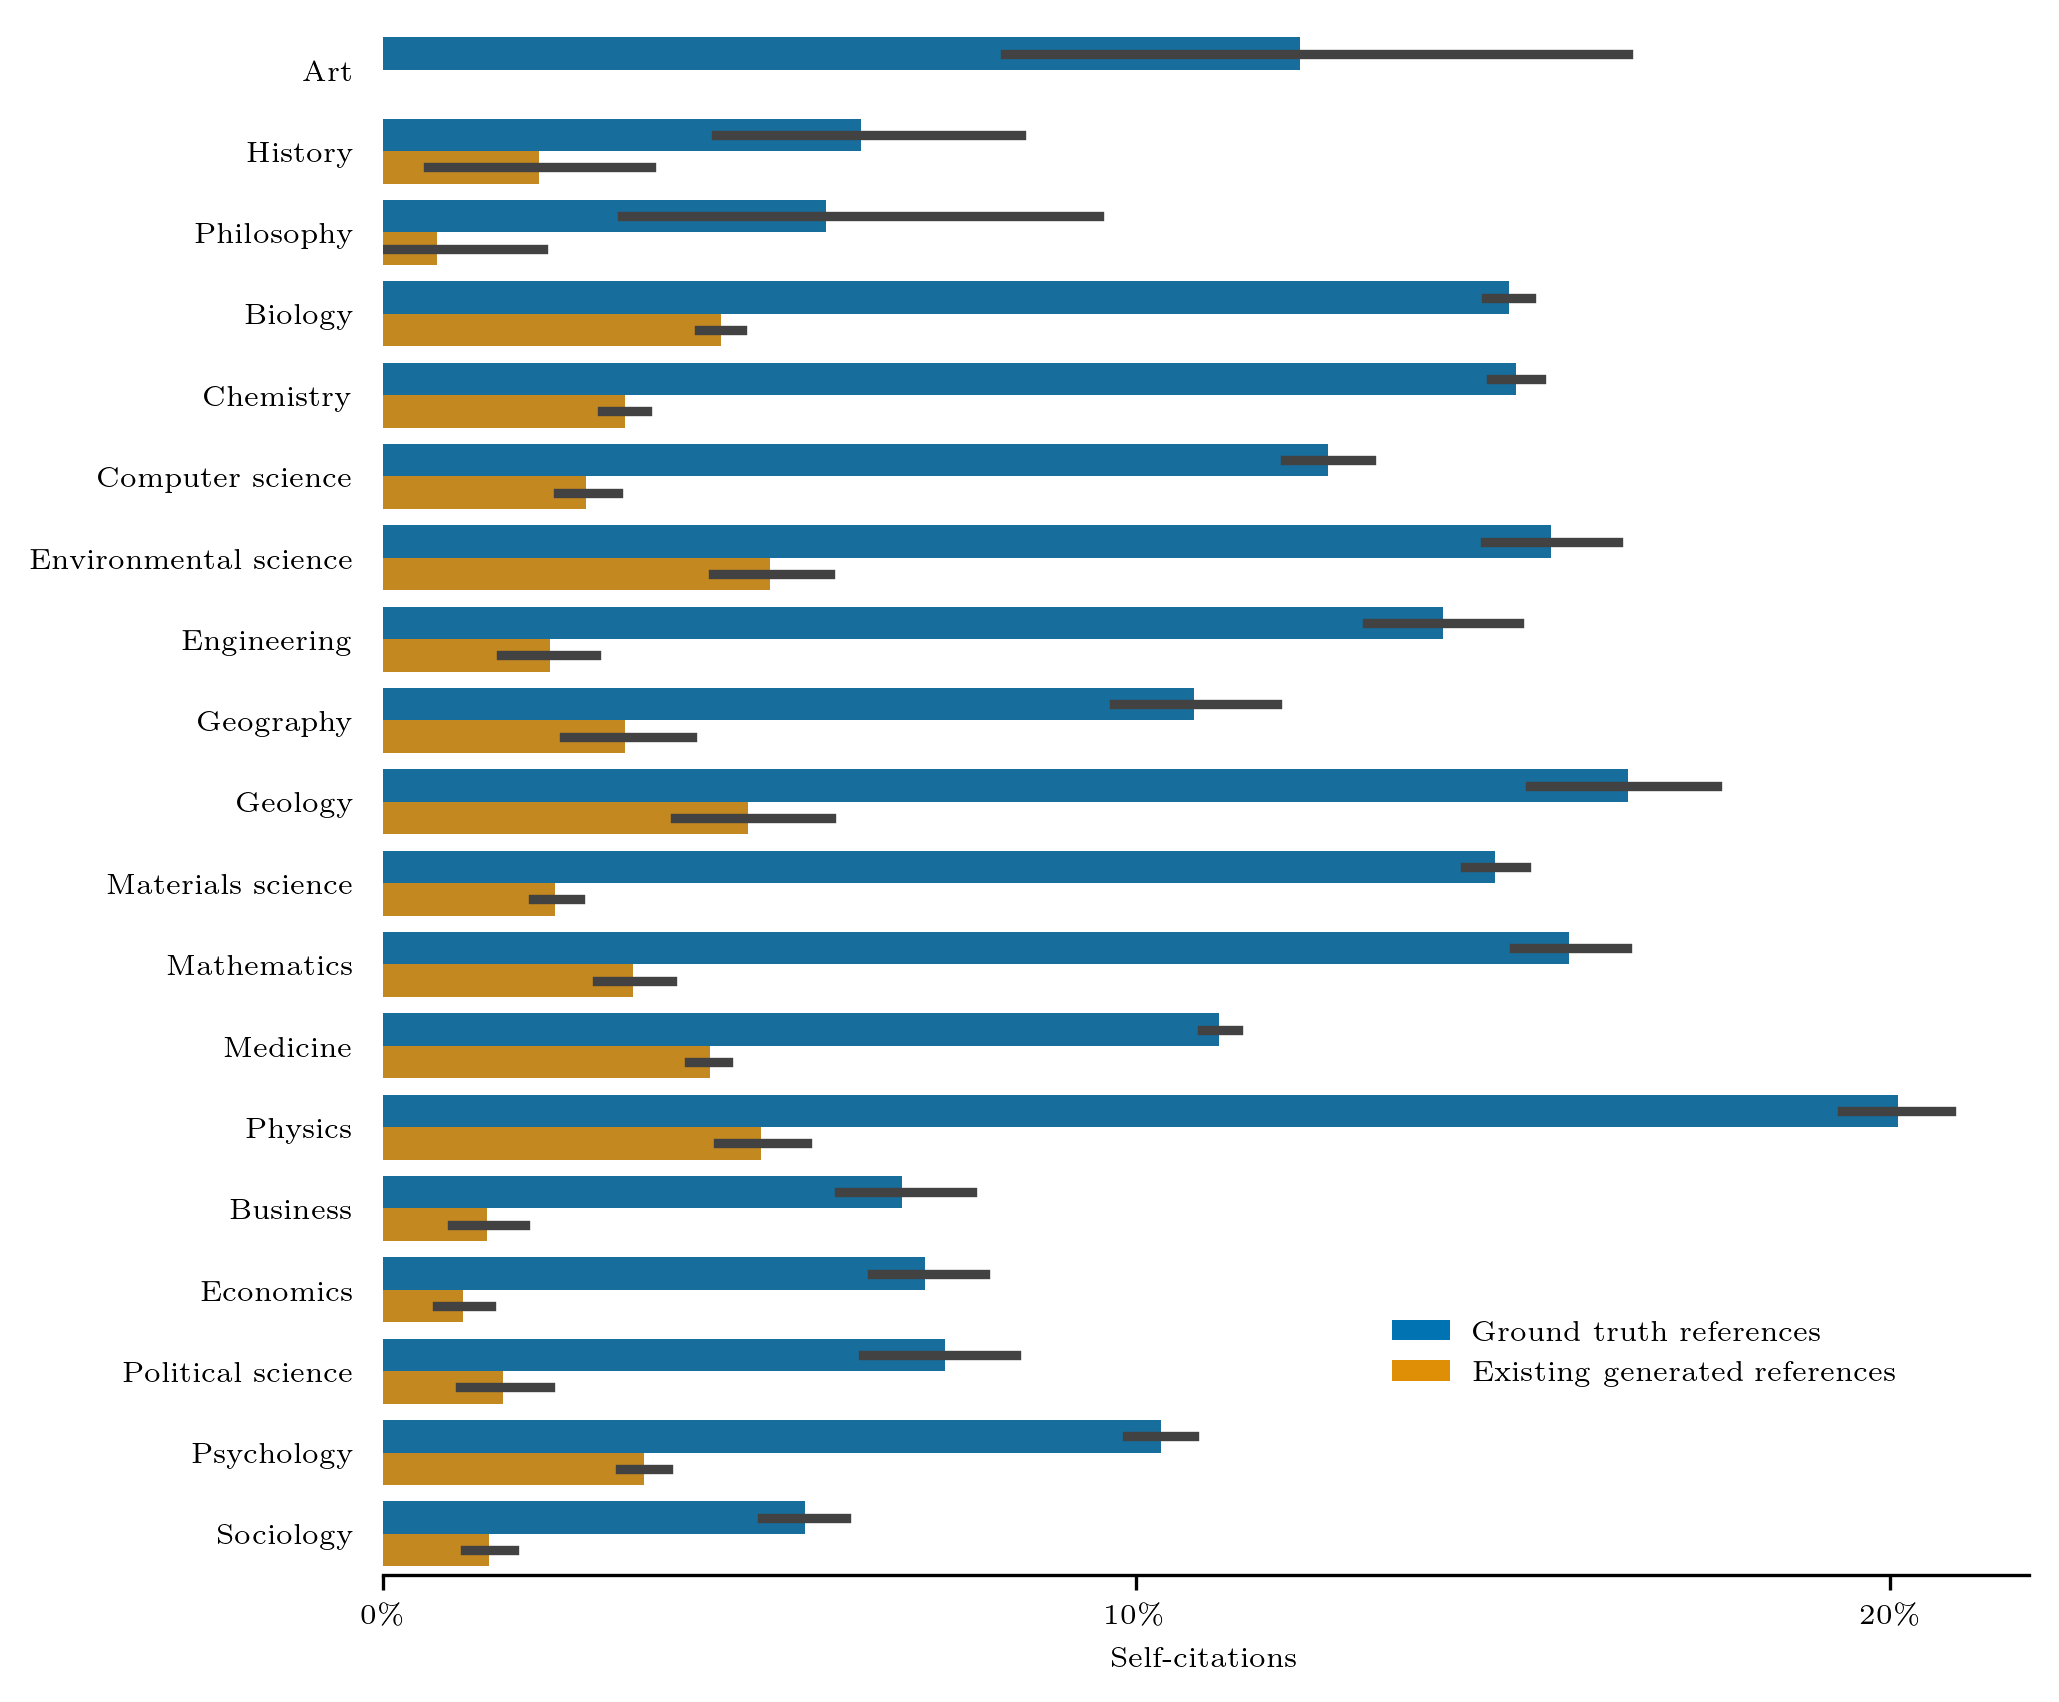

In [ ]:
# self-citations figure
Figure1, ax1 = plt.subplot_mosaic(
    [
        ['B'],
    ],
    figsize=(7.08, 6.69),
    dpi=300,
    gridspec_kw={'wspace': 0.15, 'hspace': 0.25},  # Adjust spacing
)

YLABEL = [
    'Art',
    'History',
    'Philosophy',
    'Biology',
    'Chemistry',
    'Computer science',
    'Environmental science',
    'Engineering',
    'Geography',
    'Geology',
    'Materials science',
    'Mathematics',
    'Medicine',
    'Physics',
    'Business',
    'Economics',
    'Political science',
    'Psychology',
    'Sociology',
]

# B
sns.barplot(
    self_citations,
    x="SelfCitation",
    y="top_field",
    hue="Type",
    hue_order=['Ground Truth', 'Existing generated'],
    palette=["#0173b2", "#de8f05"],
    estimator="mean",
    legend=False,
    ax=ax1["B"],
)

ax1["B"].tick_params(left=False)
ax1["B"].set_xlabel("Self-citations", fontsize=7)
ax1["B"].set_ylabel("", fontsize=7)
ax1["B"].set_yticklabels(
    labels=YLABEL,
    fontsize=7,
)

ax1["B"].set_xticks(
    [0,0.10,0.20],
    labels=[r"0$\%$",r"10$\%$",r"20$\%$"],
    fontsize=7,
)

sns.despine(ax=ax1["B"],left=True, bottom=False)

# legend
legend_elements = [
    Patch(facecolor='#0173b2', edgecolor=None, label='Ground truth references'),
    Patch(facecolor='#de8f05', edgecolor=None, label='Existing generated references'),
]

ax1["B"].legend(
    handles=legend_elements,
    loc='upper right',
    title='',
    title_fontsize=7,
    fontsize=7,
    frameon=False,
    bbox_transform=Figure1.transFigure,
    bbox_to_anchor=(0.85, 0.25),
)